In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tpot import TPOTClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

from sklearn.metrics import roc_auc_score
import scikitplot as skplt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
#valores estaticos
TEST_SIZE=0.20
RANDOM_STATE=42

In [3]:
df = pd.read_csv("../../data/processed/train/m3.0 - churn estricto - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df.info()

/home/seba/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337572 entries, 1690 to 21260067
Data columns (total 81 columns):
6m                                1337572 non-null int64
5m                                1337572 non-null int64
4m                                1337572 non-null int64
3m                                1337572 non-null int64
2m                                1337572 non-null int64
1m                                1337572 non-null int64
6m_canc                           1337572 non-null int64
5m_canc                           1337572 non-null int64
4m_canc                           1337572 non-null int64
3m_canc                           1337572 non-null int64
2m_canc                           1337572 non-null int64
1m_canc                           1337572 non-null int64
6m_dem                            1337572 non-null int64
5m_dem                            1337572 non-null int64
4m_dem                            1337572 non-null int64
3m_dem                      

In [4]:
#opcional: elimino los registros repetidos (sin considerar el id)
#df.drop_duplicates(inplace=True)
df.head()

,6m,5m,4m,3m,2m,1m,6m_canc,5m_canc,4m_canc,3m_canc,...,CITY_TIERRA DEL FUEGO,CITY_TUCUMAN,ModoPago_BA,ModoPago_CC,ModoPago_Mix,ModoPago_PP,ModoPago_SJ,ModoPago_TA,ModoPago_TM,Churn
1690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1690,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1690,1,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1690,1,1,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [5]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1] == 1

In [6]:
X.drop("ID_CUSTOMER", axis=1, inplace=True)

# split data set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [8]:
print("train: {} - test: {}".format(len(X_train), len(X_test)))

train: 1070057 - test: 267515


In [9]:
#distrib de churn
np.sum(y_train) / len(y_train)

0.022106299010239642

In [10]:
#distrib de churn
np.sum(y_test) / len(y_test)

0.022073528587182027

In [11]:
X_train.head()

,6m,5m,4m,3m,2m,1m,6m_canc,5m_canc,4m_canc,3m_canc,...,CITY_SANTIAGO DEL ESTERO,CITY_TIERRA DEL FUEGO,CITY_TUCUMAN,ModoPago_BA,ModoPago_CC,ModoPago_Mix,ModoPago_PP,ModoPago_SJ,ModoPago_TA,ModoPago_TM
7551716,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
19726755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16322188,1,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
15587038,0,0,1,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
16528296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Modelo 1: Simple Random Forest

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [13]:
#modelo sin optimizar de prueba

class_weight = dict({0:1, 1:20})
clf = RandomForestClassifier(class_weight=class_weight,
                            criterion='gini', max_depth=None, max_features='auto',
                            max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, min_samples_leaf=20,
                            min_samples_split=6, min_weight_fraction_leaf=0.0,
                            n_estimators=500,
                            n_jobs=-1, random_state=RANDOM_STATE)


In [14]:
# Fit grid search	
clf.fit(X_train, y_train)
#predict
y_pred_clf = clf.predict(X_test)
# Test data roc auc of model with best params
print('Test set roc auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred_clf))

Test set roc auc score for best params: 0.986 


/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


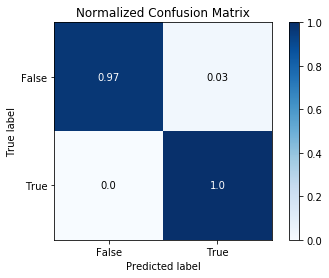

In [15]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_clf, normalize=True)

### Test set

In [16]:
#evaluación contra el testeo externo
df_testo_ext = pd.read_csv("../../data/processed/testeo/m3.0 - churn estricto - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df_testo_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1690 to 21260067
Data columns (total 80 columns):
6m                                50000 non-null int64
5m                                50000 non-null int64
4m                                50000 non-null int64
3m                                50000 non-null int64
2m                                50000 non-null int64
1m                                50000 non-null int64
Churn                             50000 non-null int64
edad_r                            50000 non-null int64
6m_canc                           50000 non-null int64
5m_canc                           50000 non-null int64
4m_canc                           50000 non-null int64
3m_canc                           50000 non-null int64
2m_canc                           50000 non-null int64
1m_canc                           50000 non-null int64
6m_dem                            50000 non-null int64
5m_dem                            50000 non-null int64
4m_de

In [17]:
X_testo_ext = df_testo_ext.drop("Churn", axis=1)
y_testeo_ext = df_testo_ext["Churn"]

In [18]:
df_testo_ext[df_testo_ext["Churn"] ==1]["1m_dif"]

311202      True
399417      True
399685      True
400053      True
402188      True
448912      True
486672      True
566396      True
580137      True
753859      True
758117      True
759750      True
886048      True
893826      True
909383      True
987622      True
1006991     True
1008349     True
1016801     True
1025684     True
1063817     True
1227086     True
1232797     True
1263004     True
1392099     True
1415578     True
1448442     True
1459124     True
1467704     True
1473255     True
            ... 
20980584    True
20980617    True
20980636    True
20980724    True
20982271    True
20983474    True
20984522    True
20987079    True
20987585    True
20987667    True
20989043    True
20989163    True
20990754    True
20990773    True
20990822    True
20992469    True
20992480    True
20996022    True
20998804    True
21008224    True
21009515    True
21042016    True
21048009    True
21048939    True
21056943    True
21056964    True
21070708    True
21071711    Tr

In [19]:
df_testo_ext.Churn.value_counts() / len(df_testo_ext)

0    0.98746
1    0.01254
Name: Churn, dtype: float64

In [20]:
y_pred_testeo_ext = clf.predict(X_testo_ext)
roc_auc_score(y_testeo_ext, y_pred_testeo_ext)

0.49994936503757115

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


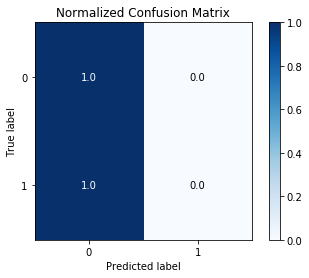

In [21]:
skplt.metrics.plot_confusion_matrix(y_testeo_ext, y_pred_testeo_ext, normalize=True)

# Modelo 2: Random Forest optimizado

In [52]:
#param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range = [2, 4, 6, 8]
#param_range_fl = [1.0, 0.5, 0.1]
class_weight_range = [{0:1, 1:1},{0:1, 1:9},{0:1, 1:15},{0:1, 1:20}]
#param_range_fl = np.power(10., np.arange(-4, 4))


#'clf__max_depth': param_range,
grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__min_samples_split': param_range,
    'clf__class_weight' : class_weight_range}]

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))])

# Construct grid searches
jobs = -1
#corregir la metrica usando una metrica compuesta (ver link)
#scoring = "roc_auc" #http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
cv = 5

#refit=True, entrena el mejor modelo obtenido con todo el dataset! :D
#verbose => mientras mayor el número, más info va mostrando.
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring=scoring,
            cv=cv,
            verbose=2,
            refit="AUC",
            n_jobs=jobs)
            
gs_rf

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0...timators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'clf__criterion': ['gini', 'entropy'], 'clf__min_samples_leaf': [2, 4, 6, 8], 'clf__min_samples_split': [2, 4, 6, 8], 'clf__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 9}, {0: 1, 1: 15}, {0: 1, 1: 20}]}],
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=2)

In [53]:
# Fit grid search	
gs_rf.fit(X_train, y_train)
# Best params
print('Best params: %s' % gs_rf.best_params_)
# Best training data roc auc
print('Best training roc auc: %.3f' % gs_rf.best_score_)
# Predict on test data with best params
y_pred_gs_rf = gs_rf.predict(X_test)
# Test data roc auc of model with best params
print('Test set roc auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred_gs_rf))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=2 
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=2 
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=2 
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=2, total=  33.2s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=2, total=  35.0s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 1

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.0min


[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=6, total=  31.8s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=6, total=  32.0s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8, total=  31.2s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8, total=  33.5s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_

[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  31.6s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=4, total=  34.3s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  30.2s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  33.1s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=gini, clf__min_s

[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=2, total=  32.0s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4, total=  30.4s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4, total=  30.5s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4, total=  31.5s
[CV] clf__class_weight={0: 1, 1: 1}, clf__cr

[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  31.0s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  34.0s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2, total=  30.3s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2, total=  30.5s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__c

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 25.4min


[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8, total=  29.3s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  32.8s
[CV] clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8, total=  30.1s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8, total=  29.7s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 1}, clf__criteri

[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=6, total=  32.8s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=6, total=  34.7s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=6, total=  32.1s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=6, total=  32.1s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_s

[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=4, total=  33.6s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=4, total=  31.4s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=4, total=  34.3s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=4, total=  31.5s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=gini, clf__min_

[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=2, total=  33.5s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=2, total=  32.6s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=2, total=  31.7s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=2, total=  32.3s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__c

[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  31.5s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  32.7s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  34.8s
[CV] clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 9}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=8, total=  30.3s
[CV] clf__class_weight={0: 1, 1: 9}, clf__cr

[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=4, total=  31.9s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=6, total=  32.1s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=6, total=  32.1s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=6, total=  32.8s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, 

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 58.4min


[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8, total=  33.1s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8, total=  32.3s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=8, total=  33.4s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=2, total=  30.6s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, 

[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  32.0s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  30.2s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  32.1s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=8, total=  33.4s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=gini, 

[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4, total=  33.1s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4, total=  31.9s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=4, total=  32.9s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=6, total=  31.8s
[CV] clf__class_weight={0: 1, 1: 15}

[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2, total=  32.4s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2, total=  30.2s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2, total=  31.8s
[CV] clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 15}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=2, total=  30.3s
[CV] clf__class_weight={0: 1, 1: 15}

[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=8, total=  31.9s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=8, total=  32.6s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=8, total=  33.1s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=2, clf__min_samples_split=8, total=  31.8s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=4, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, 

[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6, total=  31.3s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6, total=  32.7s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6, total=  32.0s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6, total=  32.6s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, 

[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=2, clf__min_samples_split=4, total=  33.7s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=2, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=2, clf__min_samples_split=4, total=  31.1s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=2, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=2, clf__min_samples_split=4, total=  32.6s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=2, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=2, clf__min_samples_split=4, total=  29.2s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=2, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20

[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=4, clf__min_samples_split=8, total=  32.7s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=2, total=  33.2s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=2 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=2, total=  31.1s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=2, total=  33.6s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=4 
[CV]  clf__class_weight={0: 1, 1: 20

[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  32.1s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  31.8s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8, total=  28.7s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8, total=  33.0s
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8, total=  29.1s
[CV]  clf__class_weig

[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 104.6min finished


Best params: {'clf__class_weight': {0: 1, 1: 1}, 'clf__criterion': 'entropy', 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 2}
Best training roc auc: 0.990
Test set roc auc score for best params: 0.675 


/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


KeyError: 'clf__min_samples_split'

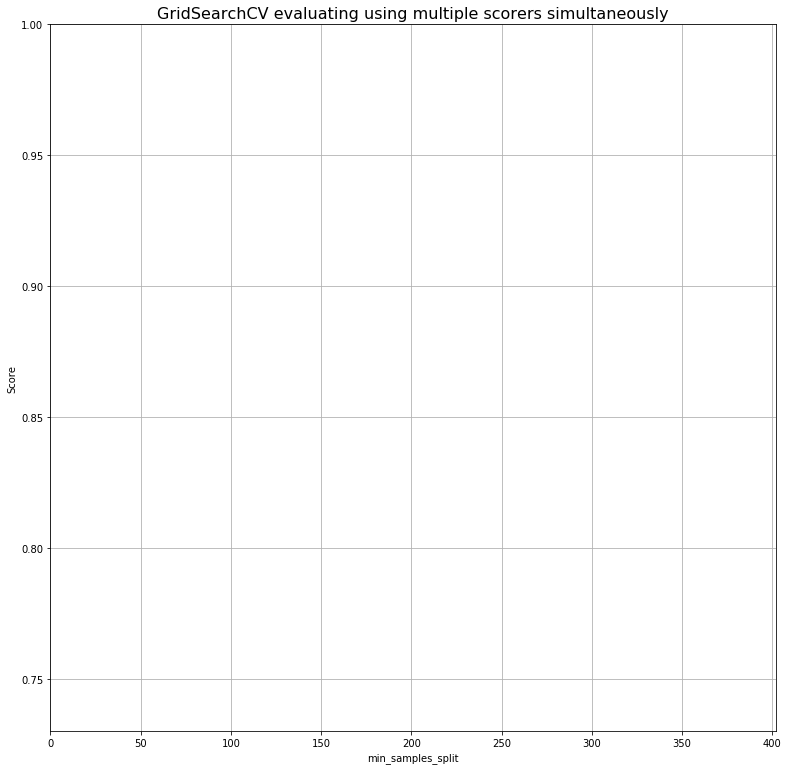

In [55]:
#plotting the result

results = gs_rf.cv_results_

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['clf__min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


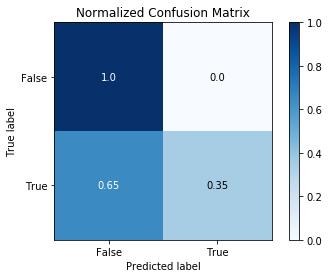

In [56]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_gs_rf, normalize=True)

In [57]:
print("Grid scores on development set:")
print()
means = gs_rf.cv_results_['mean_test_score']
stds = gs_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, gs_rf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Grid scores on development set:



KeyError: 'mean_test_score'

In [31]:
#evaluación contra el testeo externo
df_testo_ext = pd.read_csv("../../data/processed/testeo/m2.0 - churn estricto - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df_testo_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1690 to 21260067
Data columns (total 74 columns):
6m                                50000 non-null int64
5m                                50000 non-null int64
4m                                50000 non-null int64
3m                                50000 non-null int64
2m                                50000 non-null int64
1m                                50000 non-null int64
Churn                             50000 non-null int64
edad_r                            50000 non-null int64
6m_canc                           50000 non-null int64
5m_canc                           50000 non-null int64
4m_canc                           50000 non-null int64
3m_canc                           50000 non-null int64
2m_canc                           50000 non-null int64
1m_canc                           50000 non-null int64
6m_dem                            50000 non-null int64
5m_dem                            50000 non-null int64
4m_de

In [58]:
X_testo_ext = df_testo_ext.drop("Churn", axis=1)
y_testeo_ext = df_testo_ext["Churn"]

In [59]:
df_testo_ext.Churn.value_counts() / len(df_testo_ext)

0    0.98746
1    0.01254
Name: Churn, dtype: float64

In [60]:
y_pred_testeo_ext = gs_rf.predict(X_testo_ext)

In [61]:
roc_auc_score(y_testeo_ext, y_pred_testeo_ext)

0.499777206165313

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


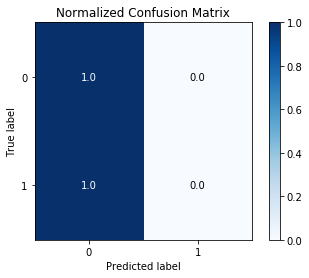

In [62]:
skplt.metrics.plot_confusion_matrix(y_testeo_ext, y_pred_testeo_ext, normalize=True)

In [63]:
#bajando el modelo
from sklearn.externals import joblib

joblib.dump(gs_rf.best_estimator_, '../../models/M2.0 - Modelo RandomForest (0.85-0.69) - Churn estricto- 6m.N.polizaXmes y Info.Cliente.M.Pago.pkl')

['../../models/M1.0 - Modelo RandomForest (0.85-0.69) - Churn estricto- 6m.N.polizaXmes y Info.Cliente.M.Pago.pkl']

# Realizando predicción para entregar

In [64]:
df_pred = pd.read_csv("../../data/processed/test_cliente/m2.0 - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1690 to 21260067
Data columns (total 55 columns):
6m                                50000 non-null int64
5m                                50000 non-null int64
4m                                50000 non-null int64
3m                                50000 non-null int64
2m                                50000 non-null int64
1m                                50000 non-null int64
edad_r                            50000 non-null int64
GENDER_F                          50000 non-null int64
GENDER_M                          50000 non-null int64
MARITAL_STATUS_Casado             50000 non-null int64
MARITAL_STATUS_Conviv             50000 non-null int64
MARITAL_STATUS_Divorciado         50000 non-null int64
MARITAL_STATUS_No Corresp         50000 non-null int64
MARITAL_STATUS_Separado           50000 non-null int64
MARITAL_STATUS_Soltero            50000 non-null int64
MARITAL_STATUS_Union Civ          50000 non-null int64
MARIT

In [65]:
y_pred_predFin  = gs_rf.best_estimator_.predict_proba(df_pred)

In [95]:
csv = pd.DataFrame()
csv["CUSTOMER_ID"] = df_pred.index.values
csv["PRED"] = pd.DataFrame(y_pred_predFin)[1]
csv.head()

,CUSTOMER_ID,PRED
0,1690,0.006911
1,5575,0.096964
2,7968,0.134929
3,9028,0.035026
4,9860,0.010475


In [96]:
csv.to_csv("../../data/processed/prediccion_para_cliente/m2.0 - predict - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv")